In [ ]:
CUDA_LAUNCH_BLOCKING=1
import os, time, random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib import pyplot as plt
import itertools
import os, time, random
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib import pyplot as plt
import itertools
import math
import pickle
from google.colab import drive
from IPython.utils.path import ensure_dir_exists
import torch.nn.functional as F
import json

# GPU support
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

#mount drive
drive.mount('/content/gdrive')


root_path = "gdrive/My Drive/BDSI ML CNN group/Workspaces/Michael's Workspace/"
data_path = root_path + "data/"
save_model_path = root_path + 'model_3_features_feats_miss_ratiocounts_timeinvar_layers_custom_reliability'  
#careful with removing #########################################################
!rm -rf "$save_model_path" 
ensure_dir_exists(save_model_path)


using device: cuda
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()
    def __len__(self):
        return len(self.X)

def get_train_val_test(batch_size=64):


    
    #Each one has a dimension of (10000, 48, 35), you can concatenate with:
    f = np.load(data_path+'data_nmiss_CF.npz') #mean of time interval
    #if no measurements in that time interval then imputed with carry forward, carry back, then col mean 
    #also rescaled ot be between [0,1]
    f2 = np.load(data_path+'data_miss_CF.npz') #missing indicator {0,1}, if 
    f3 = np.load(data_path+'data_dist_backw.npz')
    #f4 = np.load(data_path+'data_times_backw_.npz')
    f5 = np.load(data_path+'data_ratio.npz')
    f6 = np.load(data_path+'data_nmiss_inv.npz')
    
    X, y = f['X'], f['y']
    #X = np.concatenate((X,f2['X'],f3['X'],f4['X']), axis=2)
    X = np.concatenate((X,f2['X'],f3['X'],f5['X'],f6['X']), axis=2) #dimension: (10000,48,70)
    X = X.transpose((0,2,1)) #dimension: (10000,70,48)
    print("X.shape:(%i,%i,%i)"%(X.shape[0],X.shape[1],X.shape[2]))
    #print("10000 patients, 70 features, 48 time intervals")
    print("y.shape:%i"%y.shape[0])
    
    
    np.save("X.npy",X)
    np.save("y.npy",y)
    
    
    #print(X[0,1,:])
    #print(np.argwhere(np.isnan(X)),np.argwhere(np.isnan(y)))
    #X = X.transpose((0,2,1))
    #print(X.shape, y.shape)
    
    print('Creating splits')
    Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=13)
    Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=13)
    
    tr = SimpleDataset(Xtr, ytr)
    va = SimpleDataset(Xva, yva)
    te = SimpleDataset(Xte, yte)
    
    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(va, batch_size=batch_size)
    te_loader = DataLoader(te, batch_size=batch_size)
    
    print('Feature shape, Label shape, Class balance:')
    print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
    print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
    print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
    return tr_loader, va_loader, te_loader

tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143


In [ ]:



  
  
  

class CNN_V3(nn.Module):

    """

    Multilayer CNN with 1D convolutions

    """

    def __init__(

        self,

        in_channels, #constant, number of features

        L_in, #constant, number of time intervals 

        output_size, #constant, 1

        depth, #variable, 1, 2, 3, number of hidden layers in NN

        filter_size, #variable, filter size in conv layers

        n_filters, #variable, number of filters

        n_neurons, #variable, number of neurons output from fully connected layer

        dropout, #variable, dropout probability of neurons output from fully connected layer

        activation, #variable, elu or relu
        
        c1

    ):

        super().__init__()

        self.depth = depth

        if activation == 'relu':

            self.activation = F.relu

        elif activation == 'elu':

            self.activation = F.elu

        padding = int(np.floor(filter_size / 2)) #variable, based on filter size

        self.c1 = c1
        

        if depth == 1:

            self.conv1 = nn.Conv1d(in_channels, n_filters, filter_size, padding=padding)

            self.pool1 = nn.MaxPool1d(2, 2)

            self.fc1 = nn.Linear(int(L_in * (n_filters) / 2 + L_in * 35), n_neurons)
            
            #self.fc1 = nn.Linear(int(L_in * (n_filters) / 2), n_neurons)            

            self.fc1_drop = nn.Dropout(dropout)

            self.fc2 = nn.Linear(n_neurons, 1)

    

        elif depth == 2:

            self.conv1 = nn.Conv1d(in_channels, n_filters, filter_size, padding=padding)

            self.pool1 = nn.MaxPool1d(2, 2)

            self.conv2 = nn.Conv1d(n_filters, n_filters, filter_size, padding=padding)

            self.pool2 = nn.MaxPool1d(2, 2)

            self.fc1 = nn.Linear(int(L_in * (n_filters) / 4 + L_in * 35), n_neurons)
            
            #self.fc1 = nn.Linear(int(L_in * (n_filters) / 4), n_neurons)

            self.fc1_drop = nn.Dropout(dropout)

            self.fc2 = nn.Linear(n_neurons, 1)

            

        elif depth == 3:

            self.conv1 = nn.Conv1d(in_channels, n_filters, filter_size, padding=padding)

            self.pool1 = nn.MaxPool1d(2, 2)

            self.conv2 = nn.Conv1d(n_filters, n_filters, filter_size, padding=padding)

            self.pool2 = nn.MaxPool1d(2, 2)

            self.conv3 = nn.Conv1d(n_filters, n_filters, filter_size, padding=padding)

            self.pool3 = nn.MaxPool1d(2, 2)

            self.fc1 = nn.Linear(int(L_in * (n_filters) / 8 + L_in * 35), n_neurons)
           
            #self.fc1 = nn.Linear(int(L_in * (n_filters) / 8), n_neurons)

            self.fc1_drop = nn.Dropout(dropout)

            self.fc2 = nn.Linear(n_neurons, 1)

    

    def forward(self, x):
      

        xm = x[:,35:70,:]
        xd = x[:,70:105,:]
               
        xdm = torch.exp(-xd * xm * self.c1)
        
        xr = x[:,105:140,:]
        
        xinv = x[:,140:145,:]
        
        x = x[:,:35,:]
        
        x = torch.cat([x,xm,xr,xinv],dim=1)     

        x = self.pool1(self.activation(self.conv1(x)))

        if self.depth == 2 or self.depth == 3:

            x = self.pool2(self.activation(self.conv2(x)))

        if self.depth == 3:

            x = self.pool3(self.activation(self.conv3(x)))

        
        x = x.view(x.size(0), -1) # flatten
        
        xdm = xdm.view(xdm.size(0),-1) #flatten
        
        #xc = xc.view(xc.size(0), -1) # flatten       
       
        x = torch.cat((x,xdm),1)
       
        x = self.activation(self.fc1_drop(self.fc1(x)))

        x = torch.sigmoid(self.fc2(x))

        return x
      
    
def choose_hyperparameters():
  
       
  ranges = {
    "depth": [1,2,3],
    "filter_size": [2,21],
    "n_filters": [2,65],
    "n_neurons": [2,100],
    "dropout": [0,0.1,0.2],
    "activation": ["relu","elu"],
    "cost_function": ["BCELoss"],
    "optimizer": ["Adam", "SGD"],
    "learning_rate_adam": [0, 0.0002],
    "learning_rate_sgd": [0, 0.02],
    "c1": [0.0005,0.005,0.05,0.5,5]      
  }
  
  depth = random.choice(ranges['depth'])
  filter_size = random.choice(list(range(*ranges['filter_size'])))
  n_filters = random.choice(list(range(*ranges['n_filters'])))
  n_neurons = random.choice(list(range(*ranges['n_neurons'])))
  dropout = random.choice(ranges['dropout'])
  activation = random.choice(ranges['activation'])
  cost_function = random.choice(ranges['cost_function'])
  optimizer = random.choice(ranges['optimizer'])
  if optimizer == 'SGD':
    learning_rate = random.uniform(*ranges['learning_rate_sgd'])
  elif optimizer == 'Adam':
    learning_rate = random.uniform(*ranges['learning_rate_adam'])
  c1 = random.choice(ranges['c1'])  
   
  hyperparameters = {
    "depth": depth,
    "filter_size": filter_size,
    "n_filters": n_filters,
    "n_neurons": n_neurons,
    "dropout": dropout,
    "activation": activation,
    "cost_function": cost_function,
    "optimizer": optimizer,
    "learning_rate": learning_rate,
    "c1": c1
  }
  return hyperparameters




def _train_epoch(data_loader, model, criterion, optimizer):
    """
    Train the `model` for one epoch of data from `data_loader`
    Use `optimizer` to optimize the specified `criterion`
    """
    
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        # clear parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()


def _evaluate_epoch(tr_loader, va_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        # Evaluate on train
        y_true, y_score = [], []
        running_loss = []
        for X, y in tr_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            y_true.append(y.cpu().numpy())
            y_score.append(output.cpu().numpy())
            running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        train_loss = np.mean(running_loss)
        train_score = metrics.roc_auc_score(y_true, y_score)
        print('tr loss', train_loss, 'tr AUROC', train_score)

        # Evaluate on validation
        y_true, y_score = [], []
        running_loss = []
        for X, y in va_loader:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                output = model(X)
                y_true.append(y.cpu().numpy())
                y_score.append(output.cpu().numpy())
                running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        val_loss = np.mean(running_loss)
        val_score = metrics.roc_auc_score(y_true, y_score)
        print('va loss', val_loss, 'va AUROC', val_score)
    return train_loss, val_loss, train_score, val_score

def save_checkpoint(model, epoch, checkpoint_dir):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
    }

    filename = os.path.join(checkpoint_dir, 'epoch={}.checkpoint.pth.tar'.format(epoch))
    torch.save(state, filename)

    
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import datetime
import json
import os 


torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)


def create_models(num_networks):
  identifier = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
  max_AUROC_of_this_model = []
  for count in range(num_networks):
    model_params = choose_hyperparameters()
    model_params['batch_size'] = 64
    tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)

    model_params['save_dir'] = os.path.join(save_model_path + '/' 'model_' + identifier + '_' + str(count+1) + '_created/')
    ensure_dir_exists(model_params['save_dir'])
    with open(model_params['save_dir'] + 'model_params'+'.txt','w') as file:
      file.write(json.dumps(model_params))
    
    n_epochs = 30 #for early stopping
    
    model = CNN_V3(
        
        in_channels = 110, #constant, number of features

        L_in = 48, #constant, number of time intervals 

        output_size = 1, #constant, 1

        depth = model_params['depth'], #variable, 1, 2, 3, number of hidden layers in NN

        filter_size = model_params['filter_size'], #variable, filter size in conv layers

        n_filters = model_params['n_filters'], #variable, number of filters

        n_neurons = model_params['n_neurons'], #variable, number of neurons output from fully connected layer

        dropout = model_params['dropout'], #variable, dropout probability of neurons output from fully connected layer

        activation = model_params['activation'], #variable, elu or relu
        
        c1 = model_params['c1']
    )

    model = model.to(device)
    cost_function = model_params['cost_function']
    if cost_function == "BCELoss":
      criterion = torch.nn.BCELoss()

    optimizer = model_params['optimizer']
    if optimizer == "SGD":
      optimizer = torch.optim.SGD(model.parameters(), lr = model_params['learning_rate'])
      
    elif optimizer == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), lr = model_params['learning_rate'])
    
    outputs = []

    print('Epoch', 0)
    out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
    outputs.append(out)

    for epoch in range(0, n_epochs):
        print('Epoch', epoch+1)
        # Train model
        _train_epoch(tr_loader, model, criterion, optimizer)

        # Evaluate model
        out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
        outputs.append(out)

        # Save model parameters
        ensure_dir_exists(model_params['save_dir']+'checkpoint/')
        save_checkpoint(model, epoch+1, model_params['save_dir']+'checkpoint/')

    train_losses, val_losses, train_scores, val_scores = zip(*outputs)

    max_AUROC_dict = {}
    model_name = 'model_' + identifier + '_' + str(count+1) + '_created/'
    max_AUROC_dict[model_name] = max(val_scores) #max AUROC on validation set, of all epochs in this model
    max_AUROC_of_this_model.append(max_AUROC_dict) #to compare the maxes of all combos of hyperparams of this model

    with open(model_params['save_dir'] + 'max_AUROC_of_this_hyperparam_combo'+'.txt','w') as file:
      file.write(json.dumps(max_AUROC_dict))
      
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(range(n_epochs + 1), train_scores, '--o', label='Train')
    plt.plot(range(n_epochs + 1), val_scores, '--o', label='Validation')
    plt.xlabel('epoch')
    plt.ylabel('AUROC')
    plt.legend()
    plt.savefig(model_params['save_dir']+'auroc.png', dpi=300)

    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(range(n_epochs + 1), train_losses, '--o', label='Train')
    plt.plot(range(n_epochs + 1), val_losses, '--o', label='Validation')
    plt.xlabel('epoch')
    plt.ylabel('Loss (binary cross entropy)')
    plt.legend()
    plt.savefig(model_params['save_dir']+'loss.png', dpi=300)
  
  
  

X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.8185680112838745 tr AUROC 0.4248687504553399
va loss 0.8176779262721539 va AUROC 0.4223058155380209
Epoch 1
tr loss 0.39304283261299133 tr AUROC 0.6810167487267388
va loss 0.39371222257614136 va AUROC 0.6983541545968617
Epoch 2
tr loss 0.3927283922433853 tr AUROC 0.7780473135039248
va loss 0.4015602096915245 va AUROC 0.7693205277802712
Epoch 3
tr loss 0.34200405013561247 tr AUROC 0.8025874408983112
va loss 0.34700987208634615 va AUROC 0.8058196179549737
Epoch 4
tr loss 0.32586234974861145 tr AUROC 0.8150432450136527
va loss 0.33373584412038326 va AUROC 0.8134082953219476
Epoch 5
tr loss 0.34083776879310607 tr AUROC 0.8224276307739498
va loss 0.3502258826047182 va AUROC 0.8194465977429805
Epoch 6
tr loss 0.3253366122245789 tr AUROC 0.8256132559775368
va loss 0.33627110440284014

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.8455623087882995 tr AUROC 0.4864264998084223
va loss 0.8454885371029377 va AUROC 0.490962946038792
Epoch 1
tr loss 0.3441552714109421 tr AUROC 0.7872904431499074
va loss 0.357625275850296 va AUROC 0.7660647403937952
Epoch 2
tr loss 0.32268439257144926 tr AUROC 0.8274384434627603
va loss 0.33094700891524553 va AUROC 0.8175127089946227
Epoch 3
tr loss 0.3104071651697159 tr AUROC 0.8437148287775098
va loss 0.32318960037082434 va AUROC 0.8280634184951571
Epoch 4
tr loss 0.30122172129154207 tr AUROC 0.8539466601238064
va loss 0.3177028698846698 va AUROC 0.8318169578379613
Epoch 5
tr loss 0.2916970740556717 tr AUROC 0.8669127639488406
va loss 0.31411022040992975 va AUROC 0.8385814885231455
Epoch 6
tr loss 0.28428916943073274 tr AUROC 0.8815109464678443
va loss 0.3194501120597124 va 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.8493329195976257 tr AUROC 0.499191520412435
va loss 0.8489020243287086 va AUROC 0.5381351437360772
Epoch 1
tr loss 0.36134372079372407 tr AUROC 0.7657151449477012
va loss 0.36587715428322554 va AUROC 0.7661789785477068
Epoch 2
tr loss 0.33491851270198825 tr AUROC 0.8046275552146328
va loss 0.3436684161424637 va AUROC 0.794248924937373
Epoch 3
tr loss 0.3271039888858795 tr AUROC 0.8231666371293788
va loss 0.3432029252871871 va AUROC 0.8033022986348539
Epoch 4
tr loss 0.31501214563846586 tr AUROC 0.8354266530450648
va loss 0.328973020426929 va AUROC 0.8168517596755636
Epoch 5
tr loss 0.30886248993873594 tr AUROC 0.8440005047495065
va loss 0.3273866353556514 va AUROC 0.820531860205139
Epoch 6
tr loss 0.30344103038311004 tr AUROC 0.8505103188483241
va loss 0.3199747381731868 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.9125500011444092 tr AUROC 0.5861996304713042
va loss 0.9118524007499218 va AUROC 0.5900115054140724
Epoch 1
tr loss 0.4104127634763718 tr AUROC 0.38033296370256475
va loss 0.41293979808688164 va AUROC 0.37825476740295877
Epoch 2
tr loss 0.41047452425956726 tr AUROC 0.380202629622442
va loss 0.4129889849573374 va AUROC 0.37765093716085546
Epoch 3
tr loss 0.4106276854276657 tr AUROC 0.38021117821115297
va loss 0.4131164625287056 va AUROC 0.3772796631606434
Epoch 4
tr loss 0.4103117619752884 tr AUROC 0.3802141765967456
va loss 0.4128683730959892 va AUROC 0.3770960661275714
Epoch 5
tr loss 0.41037274813652036 tr AUROC 0.3804248291334882
va loss 0.4129103384912014 va AUROC 0.37731638256725775
Epoch 6
tr loss 0.4102543139457703 tr AUROC 0.3803582904915068
va loss 0.41286967881023884

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6719937906265259 tr AUROC 0.48897895528845675
va loss 0.6719547621905804 va AUROC 0.4339785069073284
Epoch 1
tr loss 0.3994079514741898 tr AUROC 0.7489916812024573
va loss 0.40196769405156374 va AUROC 0.757668236081305
Epoch 2
tr loss 0.3551639895439148 tr AUROC 0.7820186433236607
va loss 0.36024668533355 va AUROC 0.7834126200520599
Epoch 3
tr loss 0.34057040798664096 tr AUROC 0.7988074973929994
va loss 0.3486394351348281 va AUROC 0.7906993822979822
Epoch 4
tr loss 0.3340266729593277 tr AUROC 0.8082388235814989
va loss 0.3423519432544708 va AUROC 0.7971048787851588
Epoch 5
tr loss 0.3331820501089096 tr AUROC 0.8156234007281099
va loss 0.34237121511250734 va AUROC 0.7997282763910535
Epoch 6
tr loss 0.3271508234739304 tr AUROC 0.8213452773704438
va loss 0.3386704185977578 va AUR

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6639072117805481 tr AUROC 0.3949304444717489
va loss 0.663388155400753 va AUROC 0.4258961575180945
Epoch 1
tr loss 0.4120401673316956 tr AUROC 0.502999533910529
va loss 0.41259608417749405 va AUROC 0.5361767753833098
Epoch 2
tr loss 0.401718688249588 tr AUROC 0.6389219668235652
va loss 0.40195698849856853 va AUROC 0.6669794616119005
Epoch 3
tr loss 0.3894521849155426 tr AUROC 0.7026804674062088
va loss 0.3898938251659274 va AUROC 0.7209243498625062
Epoch 4
tr loss 0.3666144964694977 tr AUROC 0.7614953318964048
va loss 0.36910618655383587 va AUROC 0.7691328508131308
Epoch 5
tr loss 0.34929366219043734 tr AUROC 0.7869601103712116
va loss 0.35475508496165276 va AUROC 0.787900547527152
Epoch 6
tr loss 0.34198819077014925 tr AUROC 0.7939407985989501
va loss 0.34659614879637957 va A

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.803334234714508 tr AUROC 0.46711166536587767
va loss 0.8029146566987038 va AUROC 0.4593189774053251
Epoch 1
tr loss 0.35310770189762114 tr AUROC 0.7709710597098508
va loss 0.36053580790758133 va AUROC 0.7693286876484076
Epoch 2
tr loss 0.33169972443580625 tr AUROC 0.8121797229772412
va loss 0.34373193699866533 va AUROC 0.7988510905663765
Epoch 3
tr loss 0.3292080031633377 tr AUROC 0.824059581877043
va loss 0.3391727702692151 va AUROC 0.8134246150582207
Epoch 4
tr loss 0.3139355819225311 tr AUROC 0.8335581484573433
va loss 0.3272328907623887 va AUROC 0.8201646661389952
Epoch 5
tr loss 0.31270491993427274 tr AUROC 0.838025934376695
va loss 0.32562090642750263 va AUROC 0.8258357744938842
Epoch 6
tr loss 0.31587014806270597 tr AUROC 0.8409927412274574
va loss 0.33013916946947575 v

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6046676630973816 tr AUROC 0.4875171466188864
va loss 0.6045302376151085 va AUROC 0.5008812657587454
Epoch 1
tr loss 0.3341403993368149 tr AUROC 0.8110835897590969
va loss 0.34164880495518446 va AUROC 0.8058196179549738
Epoch 2
tr loss 0.33364836061000824 tr AUROC 0.8264876362527019
va loss 0.343627130612731 va AUROC 0.8166232833677408
Epoch 3
tr loss 0.31285434079170227 tr AUROC 0.8412738239279081
va loss 0.3264824692159891 va AUROC 0.8249055495263197
Epoch 4
tr loss 0.30172421264648436 tr AUROC 0.8506194090475457
va loss 0.3186336373910308 va AUROC 0.8331388564760793
Epoch 5
tr loss 0.3065446137189865 tr AUROC 0.859579988698
va loss 0.329187017865479 va AUROC 0.8346810715538837
Epoch 6
tr loss 0.2858597275018692 tr AUROC 0.8704674457620754
va loss 0.31472276616841555 va AUROC

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7467202649116517 tr AUROC 0.5349428029240256
va loss 0.7506823390722275 va AUROC 0.4897308059501758
Epoch 1
tr loss 0.3384988024234772 tr AUROC 0.8030435144855835
va loss 0.3516035685315728 va AUROC 0.7931065433982588
Epoch 2
tr loss 0.31865958523750304 tr AUROC 0.8305591887057578
va loss 0.3316807569935918 va AUROC 0.8202789042929067
Epoch 3
tr loss 0.30564039695262907 tr AUROC 0.846053697130647
va loss 0.3214118415489793 va AUROC 0.830413460518478
Epoch 4
tr loss 0.30476085460186003 tr AUROC 0.8552498733341575
va loss 0.32933722250163555 va AUROC 0.8274759079893269
Epoch 5
tr loss 0.29154172825813296 tr AUROC 0.8639754943859376
va loss 0.31823263317346573 va AUROC 0.8325431861021126
Epoch 6
tr loss 0.28436171686649325 tr AUROC 0.8693266557372322
va loss 0.3183733355253935 va

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7007818455696107 tr AUROC 0.42129786460081725
va loss 0.7002869136631489 va AUROC 0.4416855023622818
Epoch 1
tr loss 0.4113478472232819 tr AUROC 0.5025055658330007
va loss 0.4140673317015171 va AUROC 0.5174376382077666
Epoch 2
tr loss 0.4095141882896423 tr AUROC 0.6080580528279816
va loss 0.4119781795889139 va AUROC 0.6313575572618747
Epoch 3
tr loss 0.40915911507606506 tr AUROC 0.6454358638304236
va loss 0.41159237921237946 va AUROC 0.6742376643193445
Epoch 4
tr loss 0.4082012456655502 tr AUROC 0.6573318629760752
va loss 0.41030292212963104 va AUROC 0.6838540689182464
Epoch 5
tr loss 0.4068143507242203 tr AUROC 0.6637514703253606
va loss 0.4088472370058298 va AUROC 0.6884113552724987
Epoch 6
tr loss 0.4057270956039429 tr AUROC 0.6683124613798367
va loss 0.4077270273119211 va 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7058608140945435 tr AUROC 0.5269774321085757
va loss 0.7078612521290779 va AUROC 0.4950877593818084
Epoch 1
tr loss 0.3402962286472321 tr AUROC 0.7963107353304623
va loss 0.3514354098588228 va AUROC 0.786978482427724
Epoch 2
tr loss 0.31879388058185576 tr AUROC 0.827756144744704
va loss 0.33441188000142574 va AUROC 0.8117763216946414
Epoch 3
tr loss 0.31076661658287047 tr AUROC 0.8464417009854226
va loss 0.3337279399856925 va AUROC 0.8236489298332937
Epoch 4
tr loss 0.29458387386798857 tr AUROC 0.8574707839221716
va loss 0.32375315483659506 va AUROC 0.8238774061411167
Epoch 5
tr loss 0.28951025307178496 tr AUROC 0.8673766843750044
va loss 0.32092543691396713 va AUROC 0.8274106290442346
Epoch 6
tr loss 0.28524768072366713 tr AUROC 0.8746198908306945
va loss 0.32572108320891857 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7448845868110656 tr AUROC 0.4985154163590131
va loss 0.7439156621694565 va AUROC 0.5409992574519995
Epoch 1
tr loss 0.4068580955266953 tr AUROC 0.6706734667500092
va loss 0.40855108201503754 va AUROC 0.6999208492790756
Epoch 2
tr loss 0.40487655413150786 tr AUROC 0.7110701416807368
va loss 0.4061615075916052 va AUROC 0.7283008706579301
Epoch 3
tr loss 0.36122900128364566 tr AUROC 0.7663864643432623
va loss 0.36341538466513157 va AUROC 0.7780107873456764
Epoch 4
tr loss 0.34005984830856323 tr AUROC 0.791515359836255
va loss 0.34163619484752417 va AUROC 0.7987939714894208
Epoch 5
tr loss 0.3318414319753647 tr AUROC 0.8087083580062191
va loss 0.3369469167664647 va AUROC 0.8094262796713205
Epoch 6
tr loss 0.3293916943073273 tr AUROC 0.8152792881347758
va loss 0.33573587890714407 v

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6722298741340638 tr AUROC 0.5216182325320753
va loss 0.6721903532743454 va AUROC 0.5447446369266672
Epoch 1
tr loss 0.39567348480224607 tr AUROC 0.6556346491397631
va loss 0.4014822896569967 va AUROC 0.6326100970208322
Epoch 2
tr loss 0.3595464776754379 tr AUROC 0.7648741296866841
va loss 0.37071828730404377 va AUROC 0.7399450024887598
Epoch 3
tr loss 0.3408702746629715 tr AUROC 0.7904054468034721
va loss 0.35425452422350645 va AUROC 0.7734494210573557
Epoch 4
tr loss 0.3297582770586014 tr AUROC 0.8110401450657228
va loss 0.34428081288933754 va AUROC 0.7928209480134804
Epoch 5
tr loss 0.3256616930961609 tr AUROC 0.8157828893234633
va loss 0.3380596339702606 va AUROC 0.8046119574707671
Epoch 6
tr loss 0.3169812488555908 tr AUROC 0.8293947943688023
va loss 0.33229547273367643 va

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6947403135299682 tr AUROC 0.4517453857716524
va loss 0.6927265077829361 va AUROC 0.4203148077127074
Epoch 1
tr loss 0.3738153104782104 tr AUROC 0.744963701033652
va loss 0.3771101366728544 va AUROC 0.7489371771752168
Epoch 2
tr loss 0.3453874205350876 tr AUROC 0.794248611587982
va loss 0.3576850313693285 va AUROC 0.7893530040554544
Epoch 3
tr loss 0.33002835166454314 tr AUROC 0.8123065483082661
va loss 0.340656909160316 va AUROC 0.8105115421334792
Epoch 4
tr loss 0.3252898075580597 tr AUROC 0.8243679690250181
va loss 0.33816858660429716 va AUROC 0.8201809858752683
Epoch 5
tr loss 0.3143880171775818 tr AUROC 0.831412006122831
va loss 0.3260665787383914 va AUROC 0.82829189480298
Epoch 6
tr loss 0.31073386561870575 tr AUROC 0.8406238122086861
va loss 0.3262682957574725 va AUROC 0

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6773624906539917 tr AUROC 0.4258613436773808
va loss 0.6776128336787224 va AUROC 0.3787973986340381
Epoch 1
tr loss 0.40890647745132447 tr AUROC 0.5922186662645003
va loss 0.4104072954505682 va AUROC 0.5885468090835653
Epoch 2
tr loss 0.4013453183174133 tr AUROC 0.6359327677740151
va loss 0.4034806825220585 va AUROC 0.628366965589836
Epoch 3
tr loss 0.39595994305610654 tr AUROC 0.6605927030012309
va loss 0.39879930950701237 va AUROC 0.6521448213396871
Epoch 4
tr loss 0.39133753430843354 tr AUROC 0.6766530769624337
va loss 0.395575188100338 va AUROC 0.6614552308834689
Epoch 5
tr loss 0.38738891792297364 tr AUROC 0.6863012438451755
va loss 0.39297141321003437 va AUROC 0.6663674715016604
Epoch 6
tr loss 0.3842977285385132 tr AUROC 0.6940594070775424
va loss 0.3913116604089737 va 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7477328400611878 tr AUROC 0.5069829848635116
va loss 0.7487848065793514 va AUROC 0.4970746872730537
Epoch 1
tr loss 0.3641935966014862 tr AUROC 0.7734423673925694
va loss 0.37031283508986235 va AUROC 0.7682107857137029
Epoch 2
tr loss 0.33600372123718264 tr AUROC 0.8029662582099943
va loss 0.34449119027704 va AUROC 0.7967050452464689
Epoch 3
tr loss 0.32167933666706083 tr AUROC 0.8251566720267594
va loss 0.3352463971823454 va AUROC 0.8069293600215419
Epoch 4
tr loss 0.3129012401103973 tr AUROC 0.8385843996421841
va loss 0.3300549676641822 va AUROC 0.8178880629289031
Epoch 5
tr loss 0.3069230303764343 tr AUROC 0.8466037413983015
va loss 0.3237290205433965 va AUROC 0.8274595882530539
Epoch 6
tr loss 0.2985295126438141 tr AUROC 0.8538756558011553
va loss 0.3204237539321184 va AUR

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.81077250623703 tr AUROC 0.5740160414905116
va loss 0.8108997568488121 va AUROC 0.5460828553010584
Epoch 1
tr loss 0.6432068791389466 tr AUROC 0.5
va loss 0.6434222832322121 va AUROC 0.5
Epoch 2
tr loss 0.6422939567565918 tr AUROC 0.5
va loss 0.6425135284662247 va AUROC 0.5
Epoch 3
tr loss 0.6413695068359375 tr AUROC 0.5
va loss 0.6415933109819889 va AUROC 0.5
Epoch 4
tr loss 0.6404426884651184 tr AUROC 0.5
va loss 0.6406707391142845 va AUROC 0.5
Epoch 5
tr loss 0.6395203919410706 tr AUROC 0.5
va loss 0.6397526822984219 va AUROC 0.5
Epoch 6
tr loss 0.6385969471931457 tr AUROC 0.5
va loss 0.6388334967195988 va AUROC 0.5
Epoch 7
tr loss 0.6376767816543579 tr AUROC 0.5
va loss 0.6379175782203674 va AUROC 0.5
Epoch 8
tr loss 0.6367562279701233 tr AUROC 0.5
va loss 0.637001279741525

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6257922654151916 tr AUROC 0.42684053985741205
va loss 0.6280886679887772 va AUROC 0.38949498576103014
Epoch 1
tr loss 0.45010055804252624 tr AUROC 0.4400939145403966
va loss 0.4529367033392191 va AUROC 0.4114450310482982
Epoch 2
tr loss 0.41796343111991885 tr AUROC 0.48726177348000665
va loss 0.421742407605052 va AUROC 0.4609183115600852
Epoch 3
tr loss 0.4096257061958313 tr AUROC 0.5608318848579104
va loss 0.413402846083045 va AUROC 0.5322029196008191
Epoch 4
tr loss 0.4025620400905609 tr AUROC 0.6329814632147212
va loss 0.40622625686228275 va AUROC 0.6017413158603357
Epoch 5
tr loss 0.395634263753891 tr AUROC 0.6787296822693721
va loss 0.3993335962295532 va AUROC 0.6493133470963109
Epoch 6
tr loss 0.3882005412578583 tr AUROC 0.7062121190662747
va loss 0.3922157306224108 va A

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6006188488006592 tr AUROC 0.5097265076807794
va loss 0.6010505668818951 va AUROC 0.52474480012403
Epoch 1
tr loss 0.3723769373893738 tr AUROC 0.7565707706399614
va loss 0.37876743637025356 va AUROC 0.760050917577172
Epoch 2
tr loss 0.33740391075611115 tr AUROC 0.7988950885295675
va loss 0.35023878794163465 va AUROC 0.7912787329356759
Epoch 3
tr loss 0.3316336780786514 tr AUROC 0.811464576115677
va loss 0.3454875070601702 va AUROC 0.8049057127236824
Epoch 4
tr loss 0.3295033938884735 tr AUROC 0.8207681838370174
va loss 0.3456141399219632 va AUROC 0.8113112092108591
Epoch 5
tr loss 0.3171903246641159 tr AUROC 0.8271757338484942
va loss 0.3329196525737643 va AUROC 0.8183450155445487
Epoch 6
tr loss 0.3237027152776718 tr AUROC 0.8324407075628598
va loss 0.33909940905869007 va AURO

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.5931165909767151 tr AUROC 0.4510757250574829
va loss 0.591550312936306 va AUROC 0.45386818549012253
Epoch 1
tr loss 0.346146612405777 tr AUROC 0.7913976572528841
va loss 0.3623574022203684 va AUROC 0.7728047914745698
Epoch 2
tr loss 0.32685810232162477 tr AUROC 0.8336632195439623
va loss 0.3534922283142805 va AUROC 0.7973578346973913
Epoch 3
tr loss 0.3190819050073624 tr AUROC 0.8550206563249158
va loss 0.3466462669894099 va AUROC 0.8199361898311722
Epoch 4
tr loss 0.29868741178512576 tr AUROC 0.85788717674692
va loss 0.32959267869591713 va AUROC 0.8262600876369838
Epoch 5
tr loss 0.28162248158454894 tr AUROC 0.8729769031168028
va loss 0.32242807280272245 va AUROC 0.8254767402958769
Epoch 6
tr loss 0.2843064165711403 tr AUROC 0.8780830899856346
va loss 0.3318843198940158 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.668198145866394 tr AUROC 0.4772080589970005
va loss 0.6667691692709923 va AUROC 0.5097347226868814
Epoch 1
tr loss 0.35110176289081574 tr AUROC 0.769329858268227
va loss 0.35669212229549885 va AUROC 0.772608954639293
Epoch 2
tr loss 0.32712422251701356 tr AUROC 0.8155198607320067
va loss 0.33786903880536556 va AUROC 0.805574821910878
Epoch 3
tr loss 0.32017805659770965 tr AUROC 0.8303424118069535
va loss 0.33305067103356123 va AUROC 0.819699553655213
Epoch 4
tr loss 0.3076273453235626 tr AUROC 0.8416481117634832
va loss 0.32548328395932913 va AUROC 0.8234938923386999
Epoch 5
tr loss 0.3057280418872833 tr AUROC 0.8438073321628147
va loss 0.32242298126220703 va AUROC 0.828308214539253
Epoch 6
tr loss 0.3150658458471298 tr AUROC 0.8530759161886154
va loss 0.3366114739328623 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7638131465911865 tr AUROC 0.5201932976257506
va loss 0.7638430036604404 va AUROC 0.5570905174172385
Epoch 1
tr loss 0.39699380350112917 tr AUROC 0.6585936729470724
va loss 0.3971712701022625 va AUROC 0.6820670577963459
Epoch 2
tr loss 0.38211376547813414 tr AUROC 0.7091281447482766
va loss 0.3842924013733864 va AUROC 0.7135396691989457
Epoch 3
tr loss 0.3730022202730179 tr AUROC 0.7355739056753824
va loss 0.3777206437662244 va AUROC 0.730495875186657
Epoch 4
tr loss 0.37388029050827026 tr AUROC 0.7584350647287654
va loss 0.38259544782340527 va AUROC 0.74794167326256
Epoch 5
tr loss 0.3606465766429901 tr AUROC 0.7742637974540771
va loss 0.3715709652751684 va AUROC 0.7629231911612309
Epoch 6
tr loss 0.34883584594726563 tr AUROC 0.7859024458022665
va loss 0.35988858342170715 va A

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6772533631324769 tr AUROC 0.534375151115444
va loss 0.6778187118470669 va AUROC 0.5684735334676991
Epoch 1
tr loss 0.41111629056930543 tr AUROC 0.5796608532435706
va loss 0.4103474523872137 va AUROC 0.5955234963402992
Epoch 2
tr loss 0.404555433511734 tr AUROC 0.6199775924903073
va loss 0.4043890070170164 va AUROC 0.6318838687566809
Epoch 3
tr loss 0.4002262418270111 tr AUROC 0.6453916535917916
va loss 0.40153349190950394 va AUROC 0.6492235885468091
Epoch 4
tr loss 0.3963388271331787 tr AUROC 0.656799617635662
va loss 0.3991349469870329 va AUROC 0.6513696338667169
Epoch 5
tr loss 0.39278067874908446 tr AUROC 0.669519215887718
va loss 0.3970100786536932 va AUROC 0.658999110574373
Epoch 6
tr loss 0.39104399538040163 tr AUROC 0.6744395028498059
va loss 0.39616313204169273 va AURO

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.733995285987854 tr AUROC 0.571225246253581
va loss 0.7350651510059834 va AUROC 0.5580411420551444
Epoch 1
tr loss 0.4108415141105652 tr AUROC 0.5741712557915093
va loss 0.41273283027112484 va AUROC 0.5639692862563341
Epoch 2
tr loss 0.3977914402484894 tr AUROC 0.650009677767966
va loss 0.4005071837455034 va AUROC 0.6338585568457213
Epoch 3
tr loss 0.3839152898788452 tr AUROC 0.7060123755494542
va loss 0.3883514702320099 va AUROC 0.6876565674698698
Epoch 4
tr loss 0.3688171830177307 tr AUROC 0.7466355880810216
va loss 0.37540808133780956 va AUROC 0.7335313461334465
Epoch 5
tr loss 0.356024360537529 tr AUROC 0.7711129407642769
va loss 0.36389374546706676 va AUROC 0.7612667379295152
Epoch 6
tr loss 0.34696532928943635 tr AUROC 0.7851927215529443
va loss 0.3566913455724716 va AURO

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7314138622283936 tr AUROC 0.5362166064373934
va loss 0.7320814020931721 va AUROC 0.5799626278039347
Epoch 1
tr loss 0.4159334397315979 tr AUROC 0.5045496992619252
va loss 0.4147750250995159 va AUROC 0.5388980914068429
Epoch 2
tr loss 0.4032466940879822 tr AUROC 0.6192298461598528
va loss 0.4024505037814379 va AUROC 0.6409494822563666
Epoch 3
tr loss 0.3908058687448502 tr AUROC 0.6820431535309944
va loss 0.391166590154171 va AUROC 0.6963141875627289
Epoch 4
tr loss 0.3752183655500412 tr AUROC 0.7247128599226977
va loss 0.3774636499583721 va AUROC 0.7312139435826717
Epoch 5
tr loss 0.358942213177681 tr AUROC 0.7615704829225355
va loss 0.364891704171896 va AUROC 0.7616094523912492
Epoch 6
tr loss 0.3489069665670395 tr AUROC 0.7791578644910891
va loss 0.357171643525362 va AUROC 0.

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6549675722122192 tr AUROC 0.5812945268234938
va loss 0.6532584130764008 va AUROC 0.64296496968609
Epoch 1
tr loss 0.39353319132328035 tr AUROC 0.7180656304501241
va loss 0.3936966173350811 va AUROC 0.746481056866121
Epoch 2
tr loss 0.36992304837703704 tr AUROC 0.7754218122472185
va loss 0.3740265052765608 va AUROC 0.7809809793473739
Epoch 3
tr loss 0.3417830834388733 tr AUROC 0.794155597839172
va loss 0.34891042672097683 va AUROC 0.7955055446303988
Epoch 4
tr loss 0.34411257112026217 tr AUROC 0.8073016047997646
va loss 0.35395360086113214 va AUROC 0.8044569199761733
Epoch 5
tr loss 0.33437951815128325 tr AUROC 0.8179343266793416
va loss 0.3443637462332845 va AUROC 0.8140774045091431
Epoch 6
tr loss 0.32620951795578 tr AUROC 0.8244910942206309
va loss 0.33670100569725037 va AUR

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.8034715538024902 tr AUROC 0.5480449824186152
va loss 0.8042438924312592 va AUROC 0.49944104903264763
Epoch 1
tr loss 0.3403855813741684 tr AUROC 0.8044322773784822
va loss 0.35179234202951193 va AUROC 0.8013888095568376
Epoch 2
tr loss 0.3200820963382721 tr AUROC 0.8297378862351265
va loss 0.3310387870296836 va AUROC 0.819699553655213
Epoch 3
tr loss 0.33423935425281526 tr AUROC 0.8407119775041975
va loss 0.34729293547570705 va AUROC 0.8263906455271683
Epoch 4
tr loss 0.30456679260730746 tr AUROC 0.847013818474674
va loss 0.3253342155367136 va AUROC 0.8255909784497882
Epoch 5
tr loss 0.30066271114349363 tr AUROC 0.8499715025777823
va loss 0.32255113683640957 va AUROC 0.8292710789793637
Epoch 6
tr loss 0.2909257833957672 tr AUROC 0.8618555719765014
va loss 0.3186280485242605 va

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7009433336257934 tr AUROC 0.47142270589371604
va loss 0.7002185508608818 va AUROC 0.45308483814901557
Epoch 1
tr loss 0.40856282699108126 tr AUROC 0.5812819591221798
va loss 0.4089856240898371 va AUROC 0.6008151708268394
Epoch 2
tr loss 0.4023269770145416 tr AUROC 0.6390863676676554
va loss 0.40362039022147655 va AUROC 0.6440175926757024
Epoch 3
tr loss 0.3958440363407135 tr AUROC 0.6627810141203545
va loss 0.39853107556700706 va AUROC 0.6566082692103695
Epoch 4
tr loss 0.389072967171669 tr AUROC 0.6844122609218108
va loss 0.39356489293277264 va AUROC 0.6687093536568449
Epoch 5
tr loss 0.3847804613113403 tr AUROC 0.6934466518941951
va loss 0.39026823453605175 va AUROC 0.6748618942317892
Epoch 6
tr loss 0.38147752356529235 tr AUROC 0.700362141184153
va loss 0.3886411748826504 v

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7477976026535034 tr AUROC 0.5624177756546656
va loss 0.749114491045475 va AUROC 0.4995104079118082
Epoch 1
tr loss 0.39490389060974124 tr AUROC 0.6984548489700417
va loss 0.39622549153864384 va AUROC 0.7102430824717871
Epoch 2
tr loss 0.34250153589248655 tr AUROC 0.7919649262888369
va loss 0.3507864009588957 va AUROC 0.781446091831156
Epoch 3
tr loss 0.33000843501091004 tr AUROC 0.8108545003407315
va loss 0.34142870269715786 va AUROC 0.7954484255534431
Epoch 4
tr loss 0.32417457342147826 tr AUROC 0.8215921019206127
va loss 0.338385040871799 va AUROC 0.803347177909605
Epoch 5
tr loss 0.3204862151145935 tr AUROC 0.8289239202398812
va loss 0.3344398997724056 va AUROC 0.8076066290768741
Epoch 6
tr loss 0.3158956279754639 tr AUROC 0.8340597081920106
va loss 0.32974441163241863 va A

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6181230325698852 tr AUROC 0.5388280726977087
va loss 0.6206994913518429 va AUROC 0.5138187366892151
Epoch 1
tr loss 0.3338789485692978 tr AUROC 0.8040667295179322
va loss 0.34368000738322735 va AUROC 0.8023516739969483
Epoch 2
tr loss 0.33536515974998476 tr AUROC 0.8368173935965457
va loss 0.3530600303784013 va AUROC 0.8224739088216335
Epoch 3
tr loss 0.301049760222435 tr AUROC 0.8553911802296407
va loss 0.3209614856168628 va AUROC 0.8348687485210239
Epoch 4
tr loss 0.2975893360376358 tr AUROC 0.8640239789189249
va loss 0.32249635457992554 va AUROC 0.8390547608750643
Epoch 5
tr loss 0.2846353477239609 tr AUROC 0.8751593450556175
va loss 0.3172234706580639 va AUROC 0.8341833195975553
Epoch 6
tr loss 0.27641071379184723 tr AUROC 0.8816336888908283
va loss 0.31589084304869175 va 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.819379243850708 tr AUROC 0.5214778187727264
va loss 0.8183496594429016 va AUROC 0.5572741144503105
Epoch 1
tr loss 0.3888526194095612 tr AUROC 0.7169071690889157
va loss 0.3897446524351835 va AUROC 0.7257549917993324
Epoch 2
tr loss 0.3432397859096527 tr AUROC 0.7995600283813145
va loss 0.3532212181016803 va AUROC 0.7858769002292922
Epoch 3
tr loss 0.33197288727760316 tr AUROC 0.8148149849359831
va loss 0.34664373472332954 va AUROC 0.794526360454015
Epoch 4
tr loss 0.3267877316474915 tr AUROC 0.8265908572716146
va loss 0.3420853056013584 va AUROC 0.8077861461758779
Epoch 5
tr loss 0.3201868290901184 tr AUROC 0.8308114358681685
va loss 0.3379741879180074 va AUROC 0.8059664955814314
Epoch 6
tr loss 0.3111724772453308 tr AUROC 0.8411303479875282
va loss 0.32584582827985287 va AUR

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.661747432231903 tr AUROC 0.4513950850208184
va loss 0.6616955250501633 va AUROC 0.39654511183099284
Epoch 1
tr loss 0.3978200272321701 tr AUROC 0.6507180623130874
va loss 0.40075348503887653 va AUROC 0.6429649696860898
Epoch 2
tr loss 0.3864677065610886 tr AUROC 0.6897059425833402
va loss 0.39371288754045963 va AUROC 0.663609436071513
Epoch 3
tr loss 0.38152714133262633 tr AUROC 0.7048656525488638
va loss 0.39149157144129276 va AUROC 0.6743478225391877
Epoch 4
tr loss 0.37720238530635836 tr AUROC 0.7114911277770314
va loss 0.38837718963623047 va AUROC 0.6827035275109954
Epoch 5
tr loss 0.3731892833709717 tr AUROC 0.7198601323296013
va loss 0.38566866517066956 va AUROC 0.6904554022406999
Epoch 6
tr loss 0.3727384443283081 tr AUROC 0.7296013767565913
va loss 0.38468131981790066 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6784555888175965 tr AUROC 0.3815691917028674
va loss 0.6777293048799038 va AUROC 0.3666881543194262
Epoch 1
tr loss 0.355418621301651 tr AUROC 0.7749309701461592
va loss 0.3613351956009865 va AUROC 0.7709688211438505
Epoch 2
tr loss 0.3441089366674423 tr AUROC 0.8169619566111914
va loss 0.3608210124075413 va AUROC 0.7995528392261181
Epoch 3
tr loss 0.32033005452156066 tr AUROC 0.8310759317547025
va loss 0.33686244022101164 va AUROC 0.8121435157607851
Epoch 4
tr loss 0.31329865181446076 tr AUROC 0.8403870035423056
va loss 0.32983026932924986 va AUROC 0.8186795701381466
Epoch 5
tr loss 0.3196872947216034 tr AUROC 0.8470718723233828
va loss 0.3409415641799569 va AUROC 0.8247586718998621
Epoch 6
tr loss 0.3029057409763336 tr AUROC 0.8550395397746056
va loss 0.3238040301948786 va A

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6167857751846314 tr AUROC 0.45615320397915105
va loss 0.6175849437713623 va AUROC 0.404647860890568
Epoch 1
tr loss 0.3976927868127823 tr AUROC 0.6579765796739313
va loss 0.4016849007457495 va AUROC 0.6385504810242266
Epoch 2
tr loss 0.3801251792907715 tr AUROC 0.7162815272270636
va loss 0.38804564345628023 va AUROC 0.6873301727444084
Epoch 3
tr loss 0.3608736628293991 tr AUROC 0.7615715674449838
va loss 0.3752057272940874 va AUROC 0.7266362575580779
Epoch 4
tr loss 0.3492878788709641 tr AUROC 0.7917815781996188
va loss 0.3629402630031109 va AUROC 0.7687574968788503
Epoch 5
tr loss 0.33266649961471556 tr AUROC 0.8093389121168078
va loss 0.3471670597791672 va AUROC 0.7890755685388124
Epoch 6
tr loss 0.32479190158843996 tr AUROC 0.8215145266678329
va loss 0.34200960863381624 va 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7212953104972839 tr AUROC 0.5349433132875308
va loss 0.7218063101172447 va AUROC 0.5430637040905418
Epoch 1
tr loss 0.39152698528766633 tr AUROC 0.6749385745623857
va loss 0.39159572310745716 va AUROC 0.6931563185938915
Epoch 2
tr loss 0.35999402129650115 tr AUROC 0.7760254446829118
va loss 0.3642771104350686 va AUROC 0.7758484222894957
Epoch 3
tr loss 0.34346604299545286 tr AUROC 0.7996413037695065
va loss 0.3528948873281479 va AUROC 0.7888389323628531
Epoch 4
tr loss 0.3323213491439819 tr AUROC 0.810877785675653
va loss 0.3418809100985527 va AUROC 0.8002872273584059
Epoch 5
tr loss 0.32705776357650757 tr AUROC 0.8210384851084224
va loss 0.3390365019440651 va AUROC 0.8067416830544021
Epoch 6
tr loss 0.32123196506500246 tr AUROC 0.8271443464929287
va loss 0.33138203900307417 v

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7245833735466003 tr AUROC 0.45046686139586206
va loss 0.7243582531809807 va AUROC 0.4325138105768211
Epoch 1
tr loss 0.3692412277460098 tr AUROC 0.7618399548532443
va loss 0.3772499058395624 va AUROC 0.7575784775318031
Epoch 2
tr loss 0.3413052624464035 tr AUROC 0.7945929155676308
va loss 0.3601140845566988 va AUROC 0.7689696534504002
Epoch 3
tr loss 0.3395219900608063 tr AUROC 0.8048000580793668
va loss 0.3469241028651595 va AUROC 0.8042529232727599
Epoch 4
tr loss 0.315323234796524 tr AUROC 0.832434902177989
va loss 0.32905284874141216 va AUROC 0.8215518437222055
Epoch 5
tr loss 0.3122283062934875 tr AUROC 0.8408386752443462
va loss 0.32880302984267473 va AUROC 0.8249218692625927
Epoch 6
tr loss 0.3075746611356735 tr AUROC 0.8475276269334644
va loss 0.3256341442465782 va AUR

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7168251295089721 tr AUROC 0.5158331346105436
va loss 0.7176554165780544 va AUROC 0.5515744465569435
Epoch 1
tr loss 0.3770483149290085 tr AUROC 0.7289423698805917
va loss 0.3820241168141365 va AUROC 0.7230051162373216
Epoch 2
tr loss 0.3413451640605927 tr AUROC 0.7986093487621324
va loss 0.35463608149439096 va AUROC 0.7772437597408426
Epoch 3
tr loss 0.3301245882511139 tr AUROC 0.8160329674409774
va loss 0.3466652221977711 va AUROC 0.7941999657285539
Epoch 4
tr loss 0.31782503843307497 tr AUROC 0.828349697501171
va loss 0.3370029963552952 va AUROC 0.8030615825248264
Epoch 5
tr loss 0.31224574720859527 tr AUROC 0.8377665421252123
va loss 0.33012678008526564 va AUROC 0.8146404354105639
Epoch 6
tr loss 0.30602872121334074 tr AUROC 0.8469274394514306
va loss 0.32634178549051285 va

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.5781014943122864 tr AUROC 0.45217243243457045
va loss 0.5784769020974636 va AUROC 0.41705086045809503
Epoch 1
tr loss 0.3332307062149048 tr AUROC 0.8094662478113381
va loss 0.3403922142460942 va AUROC 0.7994794004128893
Epoch 2
tr loss 0.31712468338012695 tr AUROC 0.8361682750134577
va loss 0.3346809344366193 va AUROC 0.8130411012558036
Epoch 3
tr loss 0.3072828856706619 tr AUROC 0.8482841770343823
va loss 0.3291010372340679 va AUROC 0.8199525095674454
Epoch 4
tr loss 0.30346730768680574 tr AUROC 0.8644540239674358
va loss 0.3299663281068206 va AUROC 0.8319067163874632
Epoch 5
tr loss 0.2894636307954788 tr AUROC 0.8769252027833695
va loss 0.3193788230419159 va AUROC 0.8386304477319647
Epoch 6
tr loss 0.27193047261238096 tr AUROC 0.8917189821157145
va loss 0.3200846668332815 va

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6547990264892578 tr AUROC 0.492330703812964
va loss 0.6516003422439098 va AUROC 0.5048184021346215
Epoch 1
tr loss 0.3967732375860214 tr AUROC 0.6602494197485923
va loss 0.3977258875966072 va AUROC 0.6701944496576935
Epoch 2
tr loss 0.3831934816837311 tr AUROC 0.702728313984815
va loss 0.38934190943837166 va AUROC 0.684082545226069
Epoch 3
tr loss 0.371503192782402 tr AUROC 0.7407888637662453
va loss 0.382172554731369 va AUROC 0.7147228500787426
Epoch 4
tr loss 0.33991910064220426 tr AUROC 0.7931275981489626
va loss 0.35532371420413256 va AUROC 0.7767378479163777
Epoch 5
tr loss 0.32999411118030547 tr AUROC 0.8120603617124788
va loss 0.3429970480501652 va AUROC 0.8012582516666531
Epoch 6
tr loss 0.320982679605484 tr AUROC 0.8239816876470724
va loss 0.334400805644691 va AUROC 0

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.5688903646469117 tr AUROC 0.4877707972809363
va loss 0.569386426359415 va AUROC 0.4899429625217257
Epoch 1
tr loss 0.41024039781093596 tr AUROC 0.4969436881495253
va loss 0.4126425087451935 va AUROC 0.5213625347814379
Epoch 2
tr loss 0.41014319694042206 tr AUROC 0.512177911186798
va loss 0.4126120414584875 va AUROC 0.5315052508751459
Epoch 3
tr loss 0.4101028821468353 tr AUROC 0.5239787913341808
va loss 0.4125588424503803 va AUROC 0.5512562116996189
Epoch 4
tr loss 0.4100722348690033 tr AUROC 0.5365577844405733
va loss 0.4124740231782198 va AUROC 0.5644466385423211
Epoch 5
tr loss 0.41001926112174986 tr AUROC 0.5471380664699981
va loss 0.412415349856019 va AUROC 0.5769516364615548
Epoch 6
tr loss 0.4100130857229233 tr AUROC 0.5573704719752383
va loss 0.41238134540617466 va AUR

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6890781598091126 tr AUROC 0.5096586931300351
va loss 0.6880680173635483 va AUROC 0.5402118301768243
Epoch 1
tr loss 0.40066859948635103 tr AUROC 0.6316586648048605
va loss 0.4006343688815832 va AUROC 0.6378895317051676
Epoch 2
tr loss 0.37195467364788054 tr AUROC 0.7419650602592569
va loss 0.3764265142381191 va AUROC 0.7351062006837968
Epoch 3
tr loss 0.34726961016654967 tr AUROC 0.7840092523799846
va loss 0.35568236000835896 va AUROC 0.773424941452946
Epoch 4
tr loss 0.3446729533672333 tr AUROC 0.8001801838354865
va loss 0.3545090686529875 va AUROC 0.7872151186036833
Epoch 5
tr loss 0.32860792315006254 tr AUROC 0.8135980869534373
va loss 0.3400206910446286 va AUROC 0.80004243131431
Epoch 6
tr loss 0.3265905594825745 tr AUROC 0.8201200859809398
va loss 0.3372789826244116 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6131509532928466 tr AUROC 0.5024688834560693
va loss 0.6139472760260105 va AUROC 0.4901387993570024
Epoch 1
tr loss 0.5142308068275452 tr AUROC 0.49338664590507925
va loss 0.5145480744540691 va AUROC 0.49025303751091387
Epoch 2
tr loss 0.44020562386512757 tr AUROC 0.5190370691048773
va loss 0.4412143677473068 va AUROC 0.5202813522533475
Epoch 3
tr loss 0.41160732638835906 tr AUROC 0.5573713651113721
va loss 0.4136167224496603 va AUROC 0.557743306868161
Epoch 4
tr loss 0.4054647799730301 tr AUROC 0.6051552965971131
va loss 0.4079457949846983 va AUROC 0.6058130900604647
Epoch 5
tr loss 0.40082998943328857 tr AUROC 0.6457090358965447
va loss 0.4036312084645033 va AUROC 0.6447111814673075
Epoch 6
tr loss 0.39547390937805177 tr AUROC 0.6801172968443842
va loss 0.39861526526510715 v

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7130636739730835 tr AUROC 0.45680889349236775
va loss 0.7124489732086658 va AUROC 0.4685396283996051
Epoch 1
tr loss 0.39466652965545657 tr AUROC 0.7804108068961848
va loss 0.4033392667770386 va AUROC 0.7670439245701789
Epoch 2
tr loss 0.34628579080104827 tr AUROC 0.8094412399995866
va loss 0.3554736003279686 va AUROC 0.8018131226999371
Epoch 3
tr loss 0.3211802589893341 tr AUROC 0.8242850987508725
va loss 0.3320081066340208 va AUROC 0.8175290287308957
Epoch 4
tr loss 0.3180950425863266 tr AUROC 0.8338826758511685
va loss 0.32763184420764446 va AUROC 0.8277615033741056
Epoch 5
tr loss 0.3244408369064331 tr AUROC 0.8370380620170764
va loss 0.3391615692526102 va AUROC 0.8251585054385522
Epoch 6
tr loss 0.31445957672595976 tr AUROC 0.8420345845277435
va loss 0.32705553993582726 v

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6694037737846374 tr AUROC 0.4947971630423841
va loss 0.6702387630939484 va AUROC 0.4652104021999005
Epoch 1
tr loss 0.36954685616493227 tr AUROC 0.750724492893252
va loss 0.37644701078534126 va AUROC 0.7427683168639996
Epoch 2
tr loss 0.3433289408683777 tr AUROC 0.7891990750682196
va loss 0.3570049488916993 va AUROC 0.7775375149937578
Epoch 3
tr loss 0.3362349328994751 tr AUROC 0.8033706574923722
va loss 0.3506413884460926 va AUROC 0.7938246117942734
Epoch 4
tr loss 0.32647176456451416 tr AUROC 0.8179646933078968
va loss 0.34105263464152813 va AUROC 0.8041550048551216
Epoch 5
tr loss 0.3209682650566101 tr AUROC 0.8258900005881938
va loss 0.33607563376426697 va AUROC 0.8105237819356839
Epoch 6
tr loss 0.31814154613018036 tr AUROC 0.8310566655323838
va loss 0.3331680791452527 va

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6774642400741577 tr AUROC 0.5084987644737495
va loss 0.678013488650322 va AUROC 0.49532439555776775
Epoch 1
tr loss 0.33568261086940765 tr AUROC 0.8047022596726963
va loss 0.34392791241407394 va AUROC 0.7974231136424834
Epoch 2
tr loss 0.3100027632713318 tr AUROC 0.8426361755094162
va loss 0.3272242583334446 va AUROC 0.8222617522500836
Epoch 3
tr loss 0.3010026037693024 tr AUROC 0.8567158287072071
va loss 0.3244401514530182 va AUROC 0.821143850315379
Epoch 4
tr loss 0.30490706813335416 tr AUROC 0.8694338320733097
va loss 0.3343547098338604 va AUROC 0.8308948927385333
Epoch 5
tr loss 0.28631268167495727 tr AUROC 0.8870408626368109
va loss 0.3323964625597 va AUROC 0.8347137110264299
Epoch 6
tr loss 0.25784818494319917 tr AUROC 0.9046961863469852
va loss 0.32135253492742777 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7941963872909545 tr AUROC 0.4320976667328864
va loss 0.793720293790102 va AUROC 0.4539579440396243
Epoch 1
tr loss 0.39930672144889834 tr AUROC 0.7558692760021594
va loss 0.4027825631201267 va AUROC 0.7539718158154565
Epoch 2
tr loss 0.3374404705762863 tr AUROC 0.8019814480314067
va loss 0.349081146530807 va AUROC 0.7849221956573182
Epoch 3
tr loss 0.32427103996276857 tr AUROC 0.8184996818521499
va loss 0.340578836388886 va AUROC 0.7985981346541441
Epoch 4
tr loss 0.3187527822256088 tr AUROC 0.8292571238132932
va loss 0.33253813069313765 va AUROC 0.8102993855619294
Epoch 5
tr loss 0.31441136908531186 tr AUROC 0.835877686792724
va loss 0.32872596848756075 va AUROC 0.8172189537417075
Epoch 6
tr loss 0.31611745297908783 tr AUROC 0.8409661385297525
va loss 0.335394742898643 va AUR

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6606970057487488 tr AUROC 0.5342732698007323
va loss 0.6608841195702553 va AUROC 0.5448629550146469
Epoch 1
tr loss 0.41041057670116426 tr AUROC 0.47155699529100353
va loss 0.41284415125846863 va AUROC 0.47993080431820223
Epoch 2
tr loss 0.4113608601093292 tr AUROC 0.5851165115225406
va loss 0.41401631757616997 va AUROC 0.6047196677301695
Epoch 3
tr loss 0.4093268173933029 tr AUROC 0.6466474667916037
va loss 0.41154585033655167 va AUROC 0.6624466548620574
Epoch 4
tr loss 0.40616222739219665 tr AUROC 0.6698642854126243
va loss 0.4083925485610962 va AUROC 0.6792437434211063
Epoch 5
tr loss 0.394733494758606 tr AUROC 0.7042304413712906
va loss 0.3974910732358694 va AUROC 0.7075503259867321
Epoch 6
tr loss 0.350816686630249 tr AUROC 0.7805988120523872
va loss 0.3612942211329937 va

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.9681602230072022 tr AUROC 0.4660473022759278
va loss 0.966357234865427 va AUROC 0.4513794257084805
Epoch 1
tr loss 0.34916231501102446 tr AUROC 0.7795710037484924
va loss 0.35632642079144716 va AUROC 0.7809809793473738
Epoch 2
tr loss 0.32817574512958525 tr AUROC 0.8163427580885918
va loss 0.3378975931555033 va AUROC 0.8092059632316341
Epoch 3
tr loss 0.3155166679620743 tr AUROC 0.8323714895124765
va loss 0.32850897312164307 va AUROC 0.8227758239426851
Epoch 4
tr loss 0.31223884236812594 tr AUROC 0.839034348867395
va loss 0.3272497672587633 va AUROC 0.82949139541905
Epoch 5
tr loss 0.3037927986383438 tr AUROC 0.8462153547708972
va loss 0.3170155184343457 va AUROC 0.8362804057086438
Epoch 6
tr loss 0.3000573137998581 tr AUROC 0.8511082096945844
va loss 0.31839396711438894 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.795814971446991 tr AUROC 0.416166223352167
va loss 0.7933890968561172 va AUROC 0.43519432725967144
Epoch 1
tr loss 0.3965937443971634 tr AUROC 0.6593519455248202
va loss 0.39658388774842024 va AUROC 0.6840009465447039
Epoch 2
tr loss 0.3838267430067062 tr AUROC 0.6993566612836076
va loss 0.3856877591460943 va AUROC 0.7054695596119167
Epoch 3
tr loss 0.37831801402568815 tr AUROC 0.7156156304437444
va loss 0.3821388091892004 va AUROC 0.712144331747599
Epoch 4
tr loss 0.37291747879981996 tr AUROC 0.727257978927346
va loss 0.3788824938237667 va AUROC 0.7171463309152923
Epoch 5
tr loss 0.36631408989429476 tr AUROC 0.7389181901336271
va loss 0.3738096300512552 va AUROC 0.7263180227007532
Epoch 6
tr loss 0.36748895835876466 tr AUROC 0.7512443619186657
va loss 0.37636796571314335 va A

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6304874362945556 tr AUROC 0.49577546608628126
va loss 0.6306229867041111 va AUROC 0.5434431379588907
Epoch 1
tr loss 0.4109429107904434 tr AUROC 0.4254582203037658
va loss 0.41342190839350224 va AUROC 0.43381938947866605
Epoch 2
tr loss 0.40595038080215456 tr AUROC 0.7104493482721834
va loss 0.4085111990571022 va AUROC 0.7125033659456064
Epoch 3
tr loss 0.3701986813545227 tr AUROC 0.7604998040842096
va loss 0.37453741393983364 va AUROC 0.7629558306337769
Epoch 4
tr loss 0.3447406429052353 tr AUROC 0.7874580337659047
va loss 0.35426856484264135 va AUROC 0.7756689051904921
Epoch 5
tr loss 0.3372081120014191 tr AUROC 0.7980177098688098
va loss 0.34756827633827925 va AUROC 0.785795301547927
Epoch 6
tr loss 0.33261009764671323 tr AUROC 0.8057257936822357
va loss 0.34386430587619543

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7149304904937744 tr AUROC 0.5622838052345688
va loss 0.7147192172706127 va AUROC 0.5692976801494888
Epoch 1
tr loss 0.3766914600133896 tr AUROC 0.7470801146939905
va loss 0.37811336666345596 va AUROC 0.7616257721275225
Epoch 2
tr loss 0.342368492603302 tr AUROC 0.7921142714095257
va loss 0.34814015962183475 va AUROC 0.7989082096433321
Epoch 3
tr loss 0.3272998231649399 tr AUROC 0.8158061108629467
va loss 0.3385658832266927 va AUROC 0.8108705763314864
Epoch 4
tr loss 0.320554315328598 tr AUROC 0.8273190184025596
va loss 0.3339410098269582 va AUROC 0.8177330254343089
Epoch 5
tr loss 0.3351734348535538 tr AUROC 0.8351274524401819
va loss 0.3511697733774781 va AUROC 0.8232490962946039
Epoch 6
tr loss 0.30834705746173857 tr AUROC 0.840119955838246
va loss 0.3247544998303056 va AURO

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6863652935028076 tr AUROC 0.48864230676138504
va loss 0.6863633804023266 va AUROC 0.5167481293502296
Epoch 1
tr loss 0.4103401610851288 tr AUROC 0.4560673353194129
va loss 0.4128823187202215 va AUROC 0.4700736836092728
Epoch 2
tr loss 0.4102674107551575 tr AUROC 0.5903000184623999
va loss 0.4127822797745466 va AUROC 0.5775840262421359
Epoch 3
tr loss 0.40959448254108427 tr AUROC 0.6878471986976544
va loss 0.41213140450417995 va AUROC 0.6803738851580159
Epoch 4
tr loss 0.407063362121582 tr AUROC 0.7072200231934694
va loss 0.4097831454128027 va AUROC 0.7063671451069351
Epoch 5
tr loss 0.4011115081310272 tr AUROC 0.7132200479460995
va loss 0.404169550165534 va AUROC 0.71969220977389
Epoch 6
tr loss 0.3850279653072357 tr AUROC 0.7406138728794237
va loss 0.3897201120853424 va AUROC

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6627109518051147 tr AUROC 0.47248183775773833
va loss 0.6624909862875938 va AUROC 0.5142920090411338
Epoch 1
tr loss 0.4100359139442444 tr AUROC 0.5866056246396355
va loss 0.4101474639028311 va AUROC 0.622940653279043
Epoch 2
tr loss 0.3989026309251785 tr AUROC 0.6626486385862115
va loss 0.39911581389606 va AUROC 0.6869058596013088
Epoch 3
tr loss 0.391986821770668 tr AUROC 0.7028175000073364
va loss 0.39288219157606363 va AUROC 0.7176277631353477
Epoch 4
tr loss 0.3733390347957611 tr AUROC 0.7435086546805245
va loss 0.3765889760106802 va AUROC 0.7452489167775049
Epoch 5
tr loss 0.3543197625875473 tr AUROC 0.7763459529641339
va loss 0.36197058856487274 va AUROC 0.7720132842653261
Epoch 6
tr loss 0.34062902569770814 tr AUROC 0.7937820117534162
va loss 0.3518444513902068 va AURO

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6948129372596741 tr AUROC 0.6013360551019062
va loss 0.6948947720229626 va AUROC 0.6166167554732316
Epoch 1
tr loss 0.4100242859125137 tr AUROC 0.5604631472254535
va loss 0.4120406974107027 va AUROC 0.6108558885688407
Epoch 2
tr loss 0.40932056844234466 tr AUROC 0.6064963405022818
va loss 0.41121696680784225 va AUROC 0.655800442264853
Epoch 3
tr loss 0.4083192242383957 tr AUROC 0.6300846399595995
va loss 0.41004963405430317 va AUROC 0.6681218431510145
Epoch 4
tr loss 0.40644246923923494 tr AUROC 0.6427458653857563
va loss 0.40822276659309864 va AUROC 0.6710838752845755
Epoch 5
tr loss 0.40388498997688294 tr AUROC 0.6531919218133317
va loss 0.40547152794897556 va AUROC 0.6777668072883942
Epoch 6
tr loss 0.39925302398204804 tr AUROC 0.6647156107819905
va loss 0.40052421391010284

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.9165094871520996 tr AUROC 0.49579422194509487
va loss 0.9157555922865868 va AUROC 0.521472693001281
Epoch 1
tr loss 0.4024617360830307 tr AUROC 0.6890956754220803
va loss 0.405087536200881 va AUROC 0.6843355011383014
Epoch 2
tr loss 0.3796767734289169 tr AUROC 0.7348648831758798
va loss 0.3841521833091974 va AUROC 0.7323563251217862
Epoch 3
tr loss 0.3491087121963501 tr AUROC 0.7862706092757802
va loss 0.35991259198635817 va AUROC 0.7762645755644589
Epoch 4
tr loss 0.343433337688446 tr AUROC 0.8039540667741747
va loss 0.35793499927967787 va AUROC 0.7915643283204543
Epoch 5
tr loss 0.3328164420127869 tr AUROC 0.8095399953378293
va loss 0.34411522652953863 va AUROC 0.8056809001966528
Epoch 6
tr loss 0.3252290214300156 tr AUROC 0.8181963983392261
va loss 0.33827730640769005 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6778337550163269 tr AUROC 0.45073046414626194
va loss 0.6762997843325138 va AUROC 0.4159655979959364
Epoch 1
tr loss 0.4020469869375229 tr AUROC 0.6404187353932369
va loss 0.40472086519002914 va AUROC 0.6257639676542828
Epoch 2
tr loss 0.38952423477172854 tr AUROC 0.6996774247465821
va loss 0.39310641027987003 va AUROC 0.6878360845688735
Epoch 3
tr loss 0.37275884211063387 tr AUROC 0.7301315168475458
va loss 0.37904015462845564 va AUROC 0.7143638158807354
Epoch 4
tr loss 0.36826950061321256 tr AUROC 0.7574343056906423
va loss 0.3766952771693468 va AUROC 0.7410955438960106
Epoch 5
tr loss 0.35257147943973544 tr AUROC 0.777396536239445
va loss 0.3638832438737154 va AUROC 0.7548612414423381
Epoch 6
tr loss 0.3448499711751938 tr AUROC 0.7883207394758899
va loss 0.35569786559790373

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.5994757504463196 tr AUROC 0.4654354402287143
va loss 0.5992546081542969 va AUROC 0.48591606759634765
Epoch 1
tr loss 0.34547862911224364 tr AUROC 0.7822049260030333
va loss 0.36093378625810146 va AUROC 0.7694102863297729
Epoch 2
tr loss 0.3278590387105942 tr AUROC 0.8180286163369144
va loss 0.33901385124772787 va AUROC 0.8105033822653426
Epoch 3
tr loss 0.32351563024520874 tr AUROC 0.8312645110698481
va loss 0.3358813775703311 va AUROC 0.8261132100105262
Epoch 4
tr loss 0.31208398747444155 tr AUROC 0.8349885059759101
va loss 0.3251653164625168 va AUROC 0.8285938099240318
Epoch 5
tr loss 0.3073604358434677 tr AUROC 0.8426314546469937
va loss 0.3245570845901966 va AUROC 0.8300136269797881
Epoch 6
tr loss 0.3025291464328766 tr AUROC 0.8465276972360372
va loss 0.3209683820605278 v

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6154367928504944 tr AUROC 0.43681750842833433
va loss 0.6156453415751457 va AUROC 0.4147987368524125
Epoch 1
tr loss 0.4050063207149506 tr AUROC 0.6227244326703583
va loss 0.4064238127321005 va AUROC 0.6384362428703152
Epoch 2
tr loss 0.3968600095510483 tr AUROC 0.6675305206945383
va loss 0.39821967110037804 va AUROC 0.6816917038620656
Epoch 3
tr loss 0.3914791498184204 tr AUROC 0.6883783595156191
va loss 0.39338049106299877 va AUROC 0.6979869605307178
Epoch 4
tr loss 0.3861946905851364 tr AUROC 0.6982087899651306
va loss 0.388795068487525 va AUROC 0.70146306435688
Epoch 5
tr loss 0.3821678582429886 tr AUROC 0.7042132166029923
va loss 0.3853183379396796 va AUROC 0.7040415826880237
Epoch 6
tr loss 0.3803658685684204 tr AUROC 0.7095377752565821
va loss 0.38421930372714996 va AUR

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7331123609542847 tr AUROC 0.5372611929415196
va loss 0.7342259362339973 va AUROC 0.5833000138717759
Epoch 1
tr loss 0.34654372656345367 tr AUROC 0.7987426174324097
va loss 0.35746875405311584 va AUROC 0.7838206134588865
Epoch 2
tr loss 0.3213778339624405 tr AUROC 0.8280046279762645
va loss 0.33417388796806335 va AUROC 0.8151300274987556
Epoch 3
tr loss 0.3104240883588791 tr AUROC 0.840259412666023
va loss 0.3247635830193758 va AUROC 0.8277451836378324
Epoch 4
tr loss 0.30722197198867796 tr AUROC 0.8500816135040141
va loss 0.3241928620263934 va AUROC 0.8315232025850463
Epoch 5
tr loss 0.3009936394691467 tr AUROC 0.8527778639016194
va loss 0.32347356900572777 va AUROC 0.8301931440787917
Epoch 6
tr loss 0.2902085188627243 tr AUROC 0.862813332889317
va loss 0.3171724025160074 va A

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7210032663345337 tr AUROC 0.5273145909991527
va loss 0.7217164859175682 va AUROC 0.5776411453190917
Epoch 1
tr loss 0.4095647850036621 tr AUROC 0.5783679110987603
va loss 0.41190007142722607 va AUROC 0.573573451053031
Epoch 2
tr loss 0.39454593002796173 tr AUROC 0.6634710255792913
va loss 0.3992810621857643 va AUROC 0.6444745452913482
Epoch 3
tr loss 0.37439614307880403 tr AUROC 0.7262301706234511
va loss 0.38181534968316555 va AUROC 0.7091496601414922
Epoch 4
tr loss 0.353713755607605 tr AUROC 0.7706383027045056
va loss 0.36666938848793507 va AUROC 0.7490432554609917
Epoch 5
tr loss 0.3424127676486969 tr AUROC 0.7881689063331134
va loss 0.3545434605330229 va AUROC 0.7738166151234998
Epoch 6
tr loss 0.3332624045610428 tr AUROC 0.8047922112404755
va loss 0.34878090023994446 va 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.7004747309684753 tr AUROC 0.4803696971158465
va loss 0.70272296667099 va AUROC 0.4457980759030934
Epoch 1
tr loss 0.3489754149913788 tr AUROC 0.7869640656883764
va loss 0.36126341111958027 va AUROC 0.7671744824603633
Epoch 2
tr loss 0.3271992262601852 tr AUROC 0.8172580950350433
va loss 0.3419818403199315 va AUROC 0.7980759030934061
Epoch 3
tr loss 0.31554135036468506 tr AUROC 0.8352503862494801
va loss 0.33253281004726887 va AUROC 0.8122822335191062
Epoch 4
tr loss 0.30785730946063994 tr AUROC 0.8422947423244838
va loss 0.32958491798490286 va AUROC 0.8146485952787004
Epoch 5
tr loss 0.2984367380142212 tr AUROC 0.8548742457943814
va loss 0.32138741202652454 va AUROC 0.8262519277688474
Epoch 6
tr loss 0.31039979636669157 tr AUROC 0.8627936200989315
va loss 0.33317553624510765 v

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6258246483802795 tr AUROC 0.4583331578958785
va loss 0.6266112625598907 va AUROC 0.44798492056368366
Epoch 1
tr loss 0.40138240814208986 tr AUROC 0.642208516410292
va loss 0.4027904849499464 va AUROC 0.6459433215559236
Epoch 2
tr loss 0.38687464809417726 tr AUROC 0.6900994966412339
va loss 0.39063430950045586 va AUROC 0.6806880400812723
Epoch 3
tr loss 0.37806197345256803 tr AUROC 0.7138602989632858
va loss 0.38421501219272614 va AUROC 0.6975708072557547
Epoch 4
tr loss 0.36355426800251006 tr AUROC 0.7483566614111985
va loss 0.3730388106778264 va AUROC 0.726791295052672
Epoch 5
tr loss 0.3458219301700592 tr AUROC 0.7864241648953862
va loss 0.3578587844967842 va AUROC 0.7662932167016181
Epoch 6
tr loss 0.3329190411567688 tr AUROC 0.8073682072371842
va loss 0.344271088950336 va 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6959813747406006 tr AUROC 0.4872108647203699
va loss 0.6943176053464413 va AUROC 0.5287676151153398
Epoch 1
tr loss 0.37513675045967104 tr AUROC 0.7474456625545403
va loss 0.3774172840639949 va AUROC 0.7585576617081868
Epoch 2
tr loss 0.3390796653032303 tr AUROC 0.7970064883788318
va loss 0.3482647752389312 va AUROC 0.7983451787419116
Epoch 3
tr loss 0.32951306319236756 tr AUROC 0.8147027049648545
va loss 0.34187511168420315 va AUROC 0.8085531737807118
Epoch 4
tr loss 0.32802869206666946 tr AUROC 0.8273285239228428
va loss 0.3430722998455167 va AUROC 0.8162479294334604
Epoch 5
tr loss 0.31717345607280734 tr AUROC 0.8335961705384757
va loss 0.33184183295816183 va AUROC 0.8220087963378512
Epoch 6
tr loss 0.30896941423416135 tr AUROC 0.8398615843137734
va loss 0.3259061574935913 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6349780354499817 tr AUROC 0.4429382979453659
va loss 0.6354812756180763 va AUROC 0.42631231079305754
Epoch 1
tr loss 0.3316370688676834 tr AUROC 0.8103668480115791
va loss 0.3471075249835849 va AUROC 0.7962888919715057
Epoch 2
tr loss 0.3331896102428436 tr AUROC 0.8330864449877264
va loss 0.34732513315975666 va AUROC 0.8233633344485154
Epoch 3
tr loss 0.30329766249656676 tr AUROC 0.8450819650168784
va loss 0.3271735832095146 va AUROC 0.8210948911065598
Epoch 4
tr loss 0.30147316479682923 tr AUROC 0.8571213125120335
va loss 0.33193214796483517 va AUROC 0.8220577555466703
Epoch 5
tr loss 0.2853708584308624 tr AUROC 0.868448128758588
va loss 0.318356404080987 va AUROC 0.8374227872477581
Epoch 6
tr loss 0.2836620420217514 tr AUROC 0.873087651997416
va loss 0.3190585821866989 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.5972461795806885 tr AUROC 0.5131356083041756
va loss 0.5980760045349598 va AUROC 0.5033169863974998
Epoch 1
tr loss 0.4085852861404419 tr AUROC 0.626612637034196
va loss 0.4113879669457674 va AUROC 0.6158334081321245
Epoch 2
tr loss 0.4028810918331146 tr AUROC 0.6546973665625908
va loss 0.4051969666033983 va AUROC 0.6568775448588751
Epoch 3
tr loss 0.39087746119499206 tr AUROC 0.6889419922115977
va loss 0.3936210125684738 va AUROC 0.6898434121304601
Epoch 4
tr loss 0.3673830384016037 tr AUROC 0.7604475556203718
va loss 0.37446205876767635 va AUROC 0.7530089513753457
Epoch 5
tr loss 0.35265117514133454 tr AUROC 0.789485388994598
va loss 0.3643602402880788 va AUROC 0.7793898050607502
Epoch 6
tr loss 0.33967870569229125 tr AUROC 0.7966510839929463
va loss 0.3491983413696289 va AU

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


X.shape:(10000,145,48)
y.shape:10000
Creating splits
Feature shape, Label shape, Class balance:
	 (8000, 145, 48) (8000,) 0.142875
	 (1000, 145, 48) (1000,) 0.143
	 (1000, 145, 48) (1000,) 0.143
Epoch 0
tr loss 0.6914467420578003 tr AUROC 0.5502509648741042
va loss 0.6912944056093693 va AUROC 0.560954214979886
Epoch 1
tr loss 0.41066578376293184 tr AUROC 0.45680072767628566
va loss 0.4129228200763464 va AUROC 0.47832331029530567
Epoch 2
tr loss 0.410198431968689 tr AUROC 0.5173930606639753
va loss 0.4125288426876068 va AUROC 0.539253045670782
Epoch 3
tr loss 0.4129211939573288 tr AUROC 0.5472167262452263
va loss 0.4154944997280836 va AUROC 0.5698117518420902
Epoch 4
tr loss 0.40923987472057344 tr AUROC 0.597476941457861
va loss 0.41152964159846306 va AUROC 0.6173021843967001
Epoch 5
tr loss 0.41066797041893005 tr AUROC 0.6271390769897383
va loss 0.41267168894410133 va AUROC 0.6467919478421229
Epoch 6
tr loss 0.4103891236782074 tr AUROC 0.6346740199840486
va loss 0.41283575259149075 va 

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: ignored

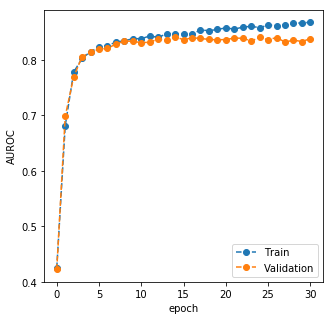

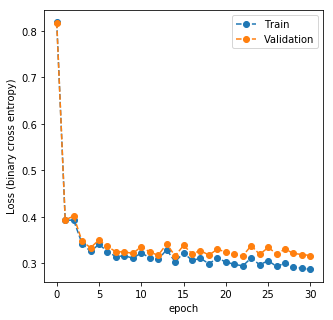

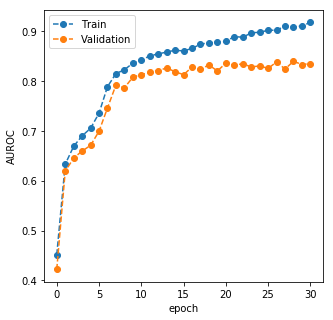

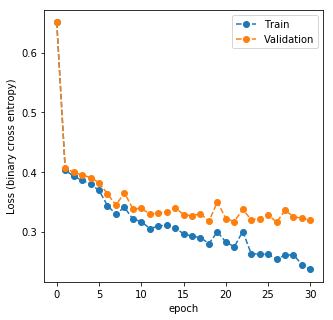

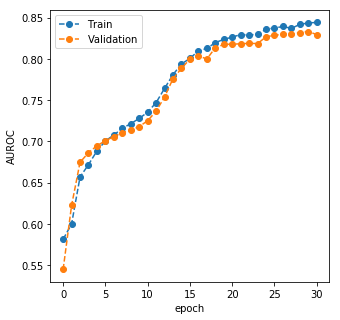

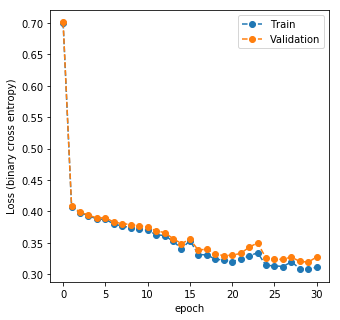

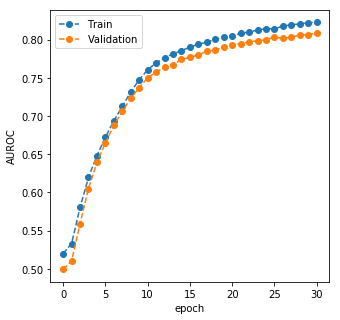

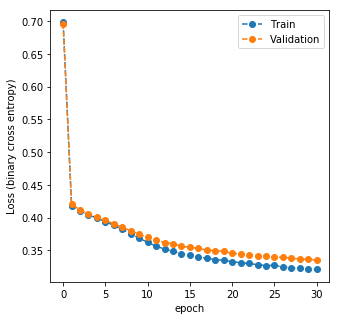

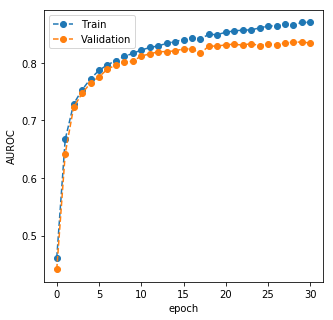

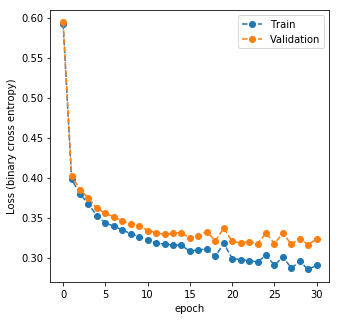

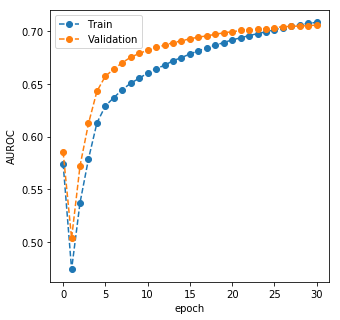

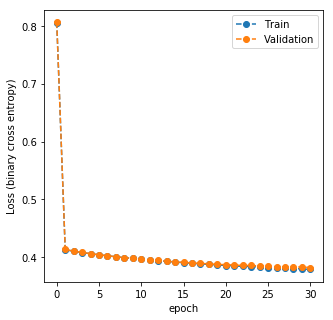

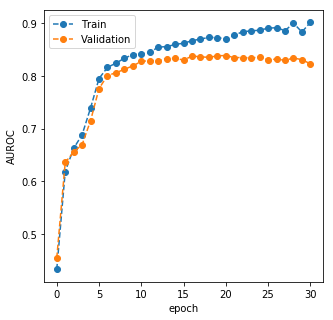

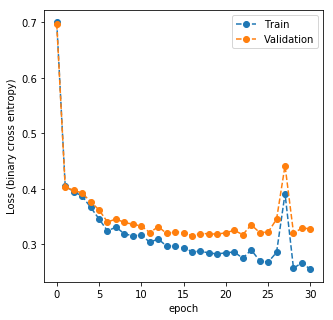

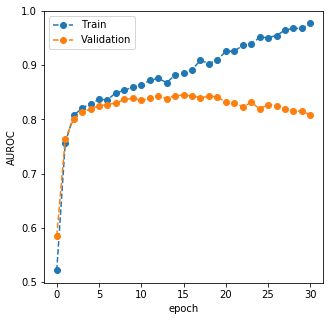

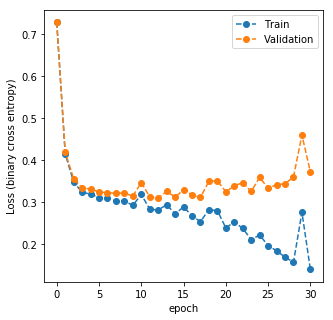

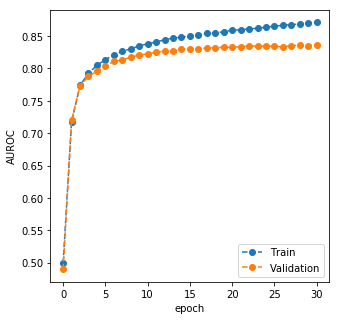

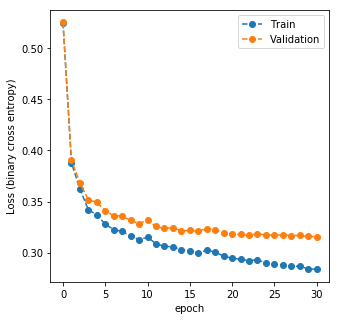

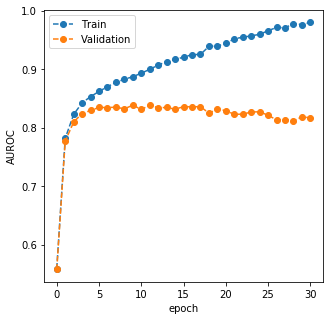

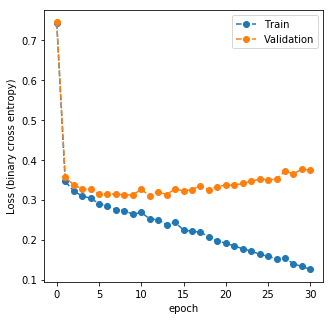

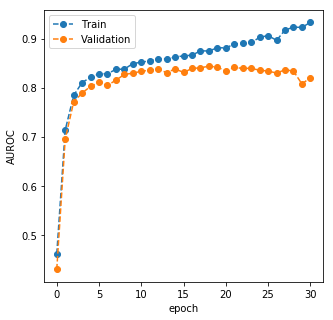

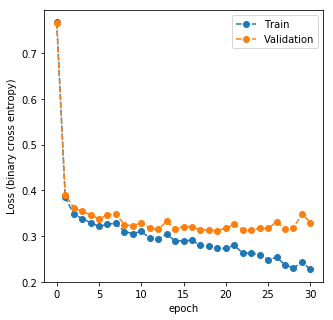

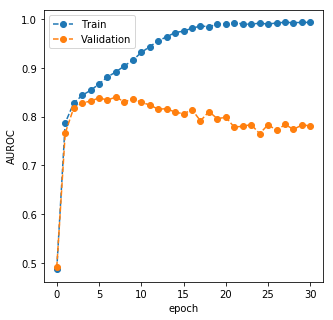

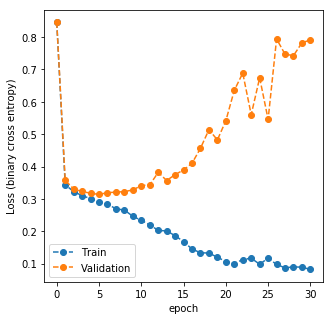

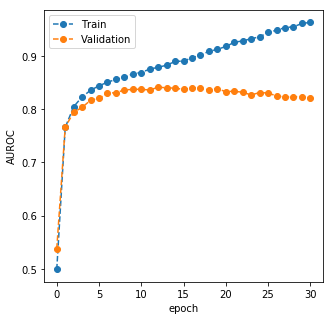

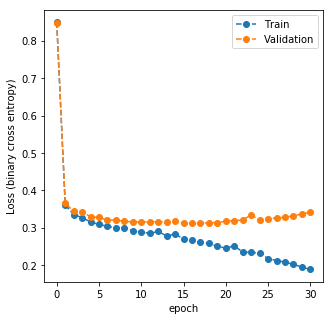

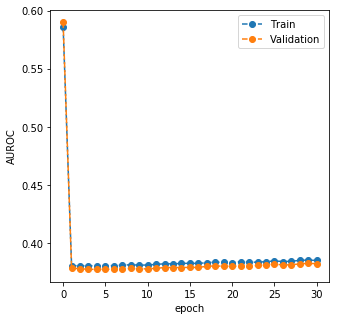

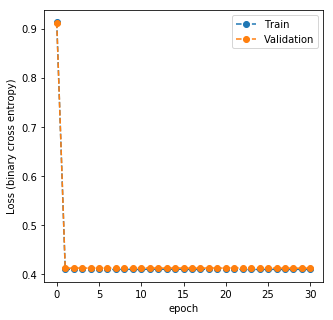

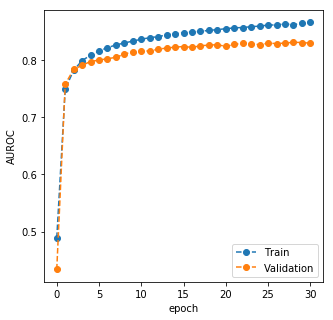

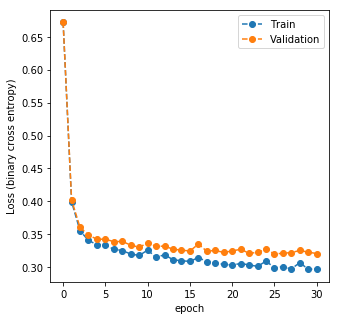

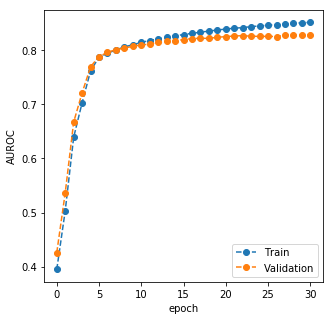

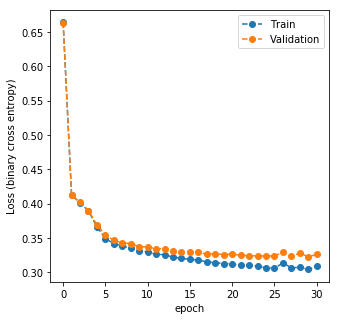

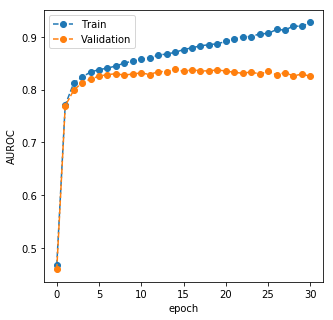

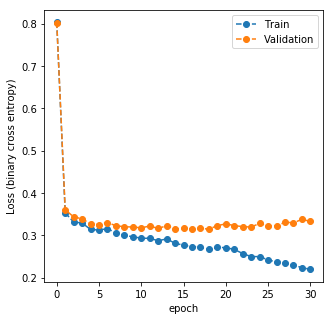

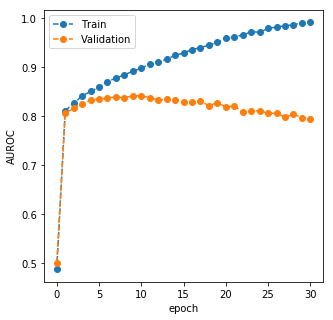

Error in callback <function flush_figures at 0x7f06a5038378> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

create_models(100)



In [ ]:
max_val = 0
temp_dict = {}
for subdirs, dirs, files in os.walk(save_model_path):
  for xdir in dirs:
    if xdir.startswith("model"):
      temp_path = save_model_path + "/" + xdir
      file_to_check = temp_path + '/max_AUROC_of_this_hyperparam_combo.txt'
      with open(file_to_check) as json_file:
        data = json.load(json_file)
      for key,val in data.items():
        if max_val < val:
          max_val = val
          max_key = key
          print("Found new max_AUROC: %s"%max_val)
          print("With model: %s"%max_key)
temp_dict[max_key] = max_val
print("Final max_AUROC: %s"%max_val)
print("With best model: %s"%max_key)
print("Writing to file %s in %s"%('max_AUROC_of_entire_model_with_these_hyperparams.txt',save_model_path))  
with open(save_model_path + '/max_AUROC_of_entire_model_with_these_hyperparams.txt','w') as file:
  file.write(json.dumps(temp_dict))
  

#copy,rename, and move max to main dir
for subdirs, dirs, files in os.walk(save_model_path):
  for xdir in dirs:
    if xdir.startswith(max_key[:-1]):
      temp_path1 = save_model_path + "/" + xdir
      file_to_cp = temp_path1 + "/auroc.png"
      rename = temp_path1 + "/auroc" + "_" + "max" + "_" + str(xdir) + ".png"
      !cp "$file_to_cp" "$rename"
      !mv "$rename" "$save_model_path"

      file_to_cp = temp_path1 + "/loss.png"
      rename = temp_path1 + "/loss" + "_" + "max" + "_" + str(xdir) + ".png"
      !cp "$file_to_cp" "$rename"
      !mv "$rename" "$save_model_path"        

      file_to_cp = temp_path1 + "/model_params.txt"
      rename = temp_path1 + "/model_params" + "_" + "max" + "_" + str(xdir) + ".txt"
      !cp "$file_to_cp" "$rename"
      !mv "$rename" "$save_model_path"

Found new max_AUROC: 0.841494561447887
With model: model_20190721181152_1_created/
Found new max_AUROC: 0.8444973929221304
With model: model_20190721181152_8_created/
Found new max_AUROC: 0.8458274514283849
With model: model_20190721181152_36_created/
Found new max_AUROC: 0.8483162112100269
With model: model_20190721181152_58_created/
Final max_AUROC: 0.8483162112100269
With best model: model_20190721181152_58_created/
Writing to file max_AUROC_of_entire_model_with_these_hyperparams.txt in gdrive/My Drive/BDSI ML CNN group/Workspaces/Michael's Workspace/model_3_features_feats_miss_ratiocounts_timeinvar_layers_custom_reliability


In [ ]:
#test with the best epoch of the best model

def get_model_from_file(model_param_txt):
  
  with open(model_param_txt) as json_file:
    best_model_params = json.load(json_file)
     
    best_model = CNN_V3(
        
        in_channels = 110, #constant, number of features

        L_in = 48, #constant, number of time intervals 

        output_size = 1, #constant, 1

        depth = best_model_params['depth'], #variable, 1, 2, 3, number of hidden layers in NN

        filter_size = best_model_params['filter_size'], #variable, filter size in conv layers

        n_filters = best_model_params['n_filters'], #variable, number of filters

        n_neurons = best_model_params['n_neurons'], #variable, number of neurons output from fully connected layer

        dropout = best_model_params['dropout'], #variable, dropout probability of neurons output from fully connected layer

        activation = best_model_params['activation'], #variable, elu or relu
        
        c1 = best_model_params['c1']
    )

    #best_model = best_model.to(device)

    cost_function = best_model_params['cost_function']
    if cost_function == "BCELoss":
      criterion = torch.nn.BCELoss()

    optimizer = best_model_params['optimizer']
    if optimizer == "SGD":
      optimizer = torch.optim.SGD(best_model.parameters(), lr = best_model_params['learning_rate'])
      
    elif optimizer == "Adam":
      optimizer = torch.optim.Adam(best_model.parameters(), lr = best_model_params['learning_rate'])
    
        
  return best_model
    

      
      
def restore_checkpoint(model, checkpoint_dir, cuda=False):
    """
    If a checkpoint exists, restores the PyTorch model from the checkpoint.
    Returns the model and the current epoch.
    """
    cp_files = [file_ for file_ in os.listdir(checkpoint_dir)
        if file_.startswith('epoch=') and file_.endswith('.checkpoint.pth.tar')]

    if not cp_files:
        print('No saved model parameters found')
        if force:
            raise Exception("Checkpoint not found")
        else:
            return model, 0, []
    
    # Find latest epoch
    for i in itertools.count(1):
        if 'epoch={}.checkpoint.pth.tar'.format(i) in cp_files:
            epoch = i
        else:
            break

    print("Which epoch to load from? Choose in range [1, {}].".format(epoch))
    inp_epoch = int(input())
    if inp_epoch not in range(1, epoch+1):
        raise Exception("Invalid epoch number")

    filename = os.path.join(checkpoint_dir,
        'epoch={}.checkpoint.pth.tar'.format(inp_epoch))

    print("Loading from checkpoint {}".format(filename))
    
    if cuda:
        checkpoint = torch.load(filename)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(filename,
            map_location=lambda storage, loc: storage)

    try:
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Successfully restored checkpoint (trained for {} epochs)"
            .format(checkpoint['epoch']))
    except:
        print("=> Checkpoint not successfully restored")
        raise

    return model, inp_epoch

file_to_check = save_model_path + '/max_AUROC_of_entire_model_with_these_hyperparams.txt'
with open(file_to_check) as json_file:
  data = json.load(json_file)
    
for key,val in data.items():
  max_val = val
  max_key = key
  

def _evaluate_epoch(data_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        y_true, y_score = [], []
        running_loss = []
        for X, y in data_loader:
            output = model(X)
            y_true.append(y.numpy())
            y_score.append(output)
            running_loss.append(criterion(output, y).item())
        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
    
    loss = np.mean(running_loss)
    score = metrics.roc_auc_score(y_true, y_score)
    return loss, score

  
  

file_to_check = save_model_path + '/max_AUROC_of_entire_model_with_these_hyperparams.txt'
with open(file_to_check) as json_file:
  data = json.load(json_file)
    
for key,val in data.items():
  max_val = val
  max_key = key  
  
model_params_dir = save_model_path + "/" + max_key + "model_params.txt"
best_model = get_model_from_file(model_params_dir)
 
checkpt_dir = save_model_path + "/" + max_key + "checkpoint/" 
best_model, _ = restore_checkpoint(best_model, checkpt_dir, cuda = True)
criterion = torch.nn.BCELoss()
loss, score = _evaluate_epoch(te_loader, best_model, criterion)
print('Test loss :', loss)
print('Test AUROC:', score)

test_loss_and_score = {}
test_loss_and_score["Test Loss"] = loss
test_loss_and_score["Test AUROC"] = score

with open(save_model_path + '/test_loss_and_auroc_score.txt','w') as file:
  file.write(json.dumps(test_loss_and_score))
    



Which epoch to load from? Choose in range [1, 30].
16
Loading from checkpoint gdrive/My Drive/BDSI ML CNN group/Workspaces/Michael's Workspace/model_3_features_feats_miss_ratiocounts_timeinvar_layers_custom_reliability/model_20190721181152_58_created/checkpoint/epoch=16.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 16 epochs)
Test loss : 0.3240236593410373
Test AUROC: 0.8400257851833114
